In [1]:
'''
Author: Ivan Gvozdanovic
Date: 10/02/2024
Description:
    GAE A2C algorithm for sampling Fibers.
''';

In [2]:
'''
Good reading material: 

    https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/03-actor-critic.ipynb
    https://github.com/Lucasc-99/Actor-Critic/blob/master/src/a2c.py
    https://github.com/pytorch/examples/blob/main/reinforcement_learning/actor_critic.py
    https://github.com/Francesco-Sovrano/Framework-for-Actor-Critic-deep-reinforcement-learning-algorithms
    https://github.com/tensorflow/docs/blob/master/site/en/tutorials/reinforcement_learning/actor_critic.ipynb
    
    https://www.reddit.com/r/reinforcementlearning/comments/aux7a5/question_about_nstep_learning_with_dqn/
    https://datascience.stackexchange.com/questions/46245/off-policy-n-step-learning-with-dqn/46260#46260
    https://people.cs.umass.edu/~barto/courses/cs687/Chapter%207.pdf
    https://arxiv.org/pdf/1606.02647
    https://arxiv.org/abs/1901.07510
''';

In [3]:
'''



''';

In [1]:
from helper_functions import create_fiber_sampling_erdos_renyi_graph, \
                             extract_distance_matrix, \
                             create_real_data_graph, \
                             create_real_data_initial_sol,\
                             moving_average, \
                             create_state_graph, \
                             create_design_mat, \
                            extract_lattice_basis_sparse, convert_sym_to_np

import numpy as np


A = create_design_mat(4)
# A = np.array([[20,10,30,40,10,10]])
print(A)
basis = extract_lattice_basis_sparse(A)
basis = convert_sym_to_np(basis)

for b in basis:
    print(b)
print("###########")
new_row = np.array([[1,0,0,0,0,1]])
# new_row = np.ones((1,A.shape[1]))
A = np.concatenate((A,new_row))
print(A)
basis = extract_lattice_basis_sparse(A)
basis = convert_sym_to_np(basis)

for b in basis:
    print(b)

[[1. 1. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0.]
 [0. 1. 0. 1. 0. 1.]
 [0. 0. 1. 0. 1. 1.]]
[ 0  1 -1 -1  1  0]
[ 1  0 -1 -1  0  1]
###########
[[1. 1. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0.]
 [0. 1. 0. 1. 0. 1.]
 [0. 0. 1. 0. 1. 1.]
 [1. 0. 0. 0. 0. 1.]]
[ 0  1 -1 -1  1  0]


In [2]:
import numpy as np
import sys
import os
import networkx as nx
import itertools
from collections import deque
import time as Time
import torch
from collections import namedtuple
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

from DeepFiberSamplingGaussianENV import PolytopeENV as Env 


In [3]:
from reward_functions import reward_cost, calculate_reward1, calculate_reward2, calculate_reward3

In [4]:
#Pick the file to the problem:
problem_name = '4x4LargeValues_'
# problem_name = '4x4_01_Values_'
# problem_name = 'Dobra_'
# problem_name = 'mediumComponent'

In [5]:
from helper_functions import create_fiber_sampling_erdos_renyi_graph, \
                             extract_distance_matrix, \
                             create_real_data_graph, \
                             create_real_data_initial_sol,\
                             moving_average, \
                             create_state_graph, \
                             create_design_mat

from stats_problems import return_stats_problem_1, return_stats_problem_2, return_stats_problem_3

initial_states = {} # dictionary holding the initial states.
patches = 1
node_num = 4
p = 0.8
graph_num = 1
available_actions = None
design_mat = None
margin = None


if problem_name == 'mediumComponent':
    path_initial = os.getcwd() + os.sep + 'Real Data' + os.sep + 'MediumComponent' + os.sep + 'nextComponentMtx.txt'
    initial_states, available_actions, node_num = create_real_data_graph(path_initial)
if problem_name == '4x4LargeValues_':
    node_num, initial_states, available_actions, design_mat, margin = return_stats_problem_1()
if problem_name == '4x4_01_Values_':
    node_num, initial_states, available_actions, design_mat, margin = return_stats_problem_2()
if problem_name == 'Dobra_':
    node_num, initial_states, available_actions, design_mat, margin = return_stats_problem_3()

print(len(available_actions))
print(len(available_actions[0]), available_actions)
print(initial_states[0].shape, initial_states[0])

print(len(margin), margin)

9
16 [[1, -1, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, -1, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, -1, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, -1, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, -1, 0, 0, -1, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, -1, 0, 0, -1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, -1, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, -1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, -1, 1]]
(16,) [10  0  0  2  0  3  0 40 10  0  2  0  0  3 40  0]
8 [12 43 12 43 20  6 42 42]


In [26]:
save_data = False  # save Q table data and cost vector data.
save_plots = True  # save the plots
save_data_rate = 20

# Example usage for running episodes
num_episodes = 800
max_path_length = 100


# n_step = max_path_length
n_step = num_episodes * max_path_length // 2000
print(f'Train every: {n_step} steps and total number of training periods: {num_episodes * max_path_length // n_step}')
gamma = 0.9
lam = 0.5
discount_factor = gamma
entropy_param = 0.01



sheduler_lr_update = 1 # every 10 trainig periods we modify the step size
actor_lr = 0.0007
critic_lr = 0.0007
step_size = num_episodes//sheduler_lr_update
lr_actor_gamma = (0.00001/actor_lr)**(1/sheduler_lr_update)
lr_critic_gamma = (0.00001/critic_lr)**(1/sheduler_lr_update)
print(step_size)
print(lr_actor_gamma)
print(lr_critic_gamma)



lb = -5
ub = 5


mask_size = 9
mask_rate = 50
mask_action_size = [(len(available_actions)//mask_size) for i in range(mask_size)]
mask_action_size[-1] += len(available_actions)%mask_size # add the remained if not divisible.
mask_range = mask_action_size[0]
print(mask_action_size)
action_space_values = [ [i+lb for i in range(ub-lb)] for j in range(len(available_actions)) ]
action_space_size = [ub-lb for i in range(len(available_actions))]
print(len(action_space_size))


Train every: 40 steps and total number of training periods: 2000
800
0.014285714285714287
0.014285714285714287
[1, 1, 1, 1, 1, 1, 1, 1, 1]
9


In [22]:
from GaussianA2C import TransformerPolicy, \
                        select_action_transformer, \
                        run_n_step_with_gae, \
                        run_n_step_with_gae_cont, \
                        visualize_gaussian_distribution, \
                        freeze_parameters, \
                        generate_mask

model = TransformerPolicy(len(initial_states[0]), len(action_space_size), mask_action_size, mask_rate, lb, ub)
print(model)

optimizer = torch.optim.Adam([
    {'params': model.transformer_encoder.parameters()},   # Shared feature extractor
    {'params': model.mean_head.parameters(), 'lr': actor_lr},  # Actor-specific parameters
    {'params': model.log_std_head.parameters(), 'lr': actor_lr},  # Actor-specific parameters
#     {'params': model.cov_head.parameters(), 'lr': actor_lr},  # Actor-specific parameters
    {'params': model.mask_heads.parameters(), 'lr': actor_lr}, # Mask-specific parameters
    {'params': model.value_head.parameters(), 'lr': critic_lr} # Critic-specific parameters
])

scheduler_actor = StepLR(optimizer, step_size=step_size, gamma=lr_actor_gamma)
scheduler_critic = StepLR(optimizer, step_size=step_size, gamma=lr_critic_gamma)
eps = np.finfo(np.float32).eps.item()
SavedAction = namedtuple('SavedAction', ['log_probs', 'value', 'probs', 'mask_log_probs'])

TransformerPolicy(
  (embedding): Linear(in_features=16, out_features=64, bias=True)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mean_head): Linear(in_features=64, out_features=9, bias=True)
  (log_std_head): Linear(in_features=64, out_fe

In [23]:
# Convert dictionary values to a list of arrays
visited_states = [np.array(initial_states[0])]
visited_states = np.stack(visited_states)

#Initialize the environment.
env = Env(initial_states, # initial_state
         num_episodes, # total_episodes
         max_path_length,
         50, # show_path_num
         visited_states,  # visited_states
         available_actions, # basis_moves
         node_num, # node_num
         0, # P
         lb, #lb
         True)



$\Large \textbf{Episodic RL}$

In [19]:
cumm_running_reward = 0
episode_reward_list = []
cumm_running_reward_list = []
loss_list = []
actor_lr_list = []
critic_lr_list = []
robins_monro_condition = []


start_time = Time.time()
iteration = 0

# run infinitely many episodes
for i_episode in range(num_episodes):

    # reset environment and episode reward
    state = env.reset()
    ep_reward = 0

    # for each episode, only run 9999 steps so that we don't
    # infinite loop while learning
    for t in range(max_path_length):

        
        # select action from policy
        action = select_action_transformer(model, state, SavedAction, action_space_values, mask_range, t, False)

        # take the action
        state, reward, done, _ = env.step(action)
       
        model.rewards.append(reward)
        ep_reward += (discount_factor**t)*reward
        cumm_running_reward += reward
        cumm_running_reward_list.append(reward)
        
        # perform backprop
        actor_lr,critic_lr = run_n_step_with_gae(model, n_step, gamma, lam, optimizer, scheduler_actor, scheduler_critic, done)
        if actor_lr != None and critic_lr != None:
            actor_lr_list.append(actor_lr)
            critic_lr_list.append(critic_lr)
            robins_monro_condition.append(critic_lr/actor_lr)
        if done:
            break
        
        iteration += 1
        
    if (i_episode + 1) % save_data_rate == 0:
        torch.save(model.state_dict(), 'Models/'+problem_name+'policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth')
        end_time = Time.time()
        print(f'It took {(end_time-start_time)/60} minutes to run {i_episode} episodes.')
        
    episode_reward_list.append(ep_reward)
    
torch.save(model.state_dict(), 'Models/'+problem_name+'policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth')


end_time = Time.time()
print(f'It took {(end_time-start_time)/60} minutes to run {num_episodes} episodes.')

Episode: 1 ||| Reward: -1586.3982049731567 ||| Discovered States: 1
Episode: 2 ||| Reward: -1404.494463142913 ||| Discovered States: 1
Episode: 3 ||| Reward: -1223.4566413020013 ||| Discovered States: 1
Episode: 4 ||| Reward: -1146.0025261951241 ||| Discovered States: 2
Episode: 5 ||| Reward: -1102.7501880439427 ||| Discovered States: 4
Episode: 6 ||| Reward: -902.6661995676568 ||| Discovered States: 6
Episode: 7 ||| Reward: -762.9902669567053 ||| Discovered States: 9
Episode: 8 ||| Reward: -748.8145922026603 ||| Discovered States: 11
Episode: 9 ||| Reward: -711.4183711066648 ||| Discovered States: 16
Episode: 10 ||| Reward: -834.1375965443286 ||| Discovered States: 19
Episode: 11 ||| Reward: -702.9644206641101 ||| Discovered States: 26
Episode: 12 ||| Reward: -766.8163479155824 ||| Discovered States: 29
Episode: 13 ||| Reward: -535.141141805707 ||| Discovered States: 42
Episode: 14 ||| Reward: -627.5297307156592 ||| Discovered States: 49
Episode: 15 ||| Reward: -655.1449198369497 ||| 

Episode: 114 ||| Reward: -340.52526348266446 ||| Discovered States: 1894
Episode: 115 ||| Reward: -424.77279355894353 ||| Discovered States: 1910
Episode: 116 ||| Reward: -366.7572252906656 ||| Discovered States: 1932
Episode: 117 ||| Reward: -390.02923387697285 ||| Discovered States: 1954
Episode: 118 ||| Reward: -394.288056415828 ||| Discovered States: 1980
Episode: 119 ||| Reward: -302.4473381839895 ||| Discovered States: 2011
Episode: 120 ||| Reward: -330.20302127202945 ||| Discovered States: 2042
It took 1.466447361310323 minutes to run 119 episodes.
Episode: 121 ||| Reward: -289.59047929297554 ||| Discovered States: 2073
Episode: 122 ||| Reward: -406.4531487601254 ||| Discovered States: 2101
Episode: 123 ||| Reward: -306.9306696486208 ||| Discovered States: 2133
Episode: 124 ||| Reward: -308.9279713086944 ||| Discovered States: 2169
Episode: 125 ||| Reward: -272.24990812086213 ||| Discovered States: 2203
Episode: 126 ||| Reward: -357.5150326428174 ||| Discovered States: 2241
Epis

Episode: 223 ||| Reward: -310.8698305247393 ||| Discovered States: 4982
Episode: 224 ||| Reward: -486.00242682841747 ||| Discovered States: 5031
Episode: 225 ||| Reward: -239.0925370705279 ||| Discovered States: 5075
Episode: 226 ||| Reward: -374.8826809524323 ||| Discovered States: 5115
Episode: 227 ||| Reward: -322.5894129239575 ||| Discovered States: 5144
Episode: 228 ||| Reward: -222.28050607332673 ||| Discovered States: 5184
Episode: 229 ||| Reward: -255.4271781199798 ||| Discovered States: 5225
Episode: 230 ||| Reward: -236.61752411372478 ||| Discovered States: 5268
Episode: 231 ||| Reward: -285.0983481018956 ||| Discovered States: 5304
Episode: 232 ||| Reward: -261.0453140034802 ||| Discovered States: 5342
Episode: 233 ||| Reward: -221.08549767420268 ||| Discovered States: 5391
Episode: 234 ||| Reward: -377.05060481603897 ||| Discovered States: 5423
Episode: 235 ||| Reward: -438.87258948410766 ||| Discovered States: 5467
Episode: 236 ||| Reward: -324.2339363321946 ||| Discovered

Episode: 333 ||| Reward: -298.961618370257 ||| Discovered States: 8303
Episode: 334 ||| Reward: -405.82209896914134 ||| Discovered States: 8333
Episode: 335 ||| Reward: -249.2073869662348 ||| Discovered States: 8369
Episode: 336 ||| Reward: -287.4709103007095 ||| Discovered States: 8404
Episode: 337 ||| Reward: -314.69333455001635 ||| Discovered States: 8433
Episode: 338 ||| Reward: -382.72083173383896 ||| Discovered States: 8452
Episode: 339 ||| Reward: -306.4805682234547 ||| Discovered States: 8486
Episode: 340 ||| Reward: -307.60276685606715 ||| Discovered States: 8514
It took 4.520366819699605 minutes to run 339 episodes.
Episode: 341 ||| Reward: -338.48863155278895 ||| Discovered States: 8540
Episode: 342 ||| Reward: -293.6781480361485 ||| Discovered States: 8574
Episode: 343 ||| Reward: -292.28773282821095 ||| Discovered States: 8607
Episode: 344 ||| Reward: -306.7362921994985 ||| Discovered States: 8635
Episode: 345 ||| Reward: -384.3769193496984 ||| Discovered States: 8655
Epis

Episode: 442 ||| Reward: -410.1879908417413 ||| Discovered States: 11445
Episode: 443 ||| Reward: -331.53417197030797 ||| Discovered States: 11471
Episode: 444 ||| Reward: -299.4740984755676 ||| Discovered States: 11497
Episode: 445 ||| Reward: -313.4918245579769 ||| Discovered States: 11526
Episode: 446 ||| Reward: -373.3035062006804 ||| Discovered States: 11558
Episode: 447 ||| Reward: -305.5601667219418 ||| Discovered States: 11593
Episode: 448 ||| Reward: -359.83548319232233 ||| Discovered States: 11620
Episode: 449 ||| Reward: -261.09382246324583 ||| Discovered States: 11654
Episode: 450 ||| Reward: -353.5493383865502 ||| Discovered States: 11675
Episode: 451 ||| Reward: -330.5740160434205 ||| Discovered States: 11702
Episode: 452 ||| Reward: -336.18629995865246 ||| Discovered States: 11730
Episode: 453 ||| Reward: -301.8612728062674 ||| Discovered States: 11760
Episode: 454 ||| Reward: -276.67353211118876 ||| Discovered States: 11791
Episode: 455 ||| Reward: -327.94818571093026 |

Episode: 550 ||| Reward: -316.8102595437971 ||| Discovered States: 14638
Episode: 551 ||| Reward: -272.55237162848834 ||| Discovered States: 14667
Episode: 552 ||| Reward: -322.91173280844 ||| Discovered States: 14703
Episode: 553 ||| Reward: -324.231763620537 ||| Discovered States: 14731
Episode: 554 ||| Reward: -451.12636009415087 ||| Discovered States: 14762
Episode: 555 ||| Reward: -291.2889473592206 ||| Discovered States: 14795
Episode: 556 ||| Reward: -331.831690881475 ||| Discovered States: 14824
Episode: 557 ||| Reward: -309.80580091087097 ||| Discovered States: 14860
Episode: 558 ||| Reward: -393.6081701675449 ||| Discovered States: 14880
Episode: 559 ||| Reward: -325.30858842271584 ||| Discovered States: 14911
Episode: 560 ||| Reward: -329.8013875393645 ||| Discovered States: 14941
It took 8.679418313503266 minutes to run 559 episodes.
Episode: 561 ||| Reward: -277.0291296641506 ||| Discovered States: 14971
Episode: 562 ||| Reward: -344.4981060597585 ||| Discovered States: 14

Episode: 659 ||| Reward: -318.18657016152 ||| Discovered States: 17815
Episode: 660 ||| Reward: -282.3170492649676 ||| Discovered States: 17850
It took 10.903520766894022 minutes to run 659 episodes.
Episode: 661 ||| Reward: -337.14079543191286 ||| Discovered States: 17879
Episode: 662 ||| Reward: -384.57957909678805 ||| Discovered States: 17910
Episode: 663 ||| Reward: -334.79098973079243 ||| Discovered States: 17935
Episode: 664 ||| Reward: -344.73296394393174 ||| Discovered States: 17961
Episode: 665 ||| Reward: -347.49952331659915 ||| Discovered States: 17984
Episode: 666 ||| Reward: -285.0410348758649 ||| Discovered States: 18023
Episode: 667 ||| Reward: -394.95171790268535 ||| Discovered States: 18042
Episode: 668 ||| Reward: -320.8331311510953 ||| Discovered States: 18073
Episode: 669 ||| Reward: -311.48051770616314 ||| Discovered States: 18107
Episode: 670 ||| Reward: -356.3210207135836 ||| Discovered States: 18129
Episode: 671 ||| Reward: -304.8588579319167 ||| Discovered Stat

Episode: 767 ||| Reward: -358.4810559478841 ||| Discovered States: 20999
Episode: 768 ||| Reward: -376.21333572641737 ||| Discovered States: 21031
Episode: 769 ||| Reward: -428.80642111984776 ||| Discovered States: 21052
Episode: 770 ||| Reward: -297.41003251322076 ||| Discovered States: 21087
Episode: 771 ||| Reward: -291.65739549459187 ||| Discovered States: 21119
Episode: 772 ||| Reward: -336.20481323121453 ||| Discovered States: 21147
Episode: 773 ||| Reward: -301.07527692624046 ||| Discovered States: 21179
Episode: 774 ||| Reward: -373.10043325402995 ||| Discovered States: 21214
Episode: 775 ||| Reward: -334.7369363999479 ||| Discovered States: 21248
Episode: 776 ||| Reward: -367.89666940335815 ||| Discovered States: 21276
Episode: 777 ||| Reward: -269.9417240431817 ||| Discovered States: 21307
Episode: 778 ||| Reward: -286.83359715310854 ||| Discovered States: 21343
Episode: 779 ||| Reward: -318.5364180221095 ||| Discovered States: 21372
Episode: 780 ||| Reward: -347.012835131813

$\Large \textbf{Continues RL}$

In [24]:
cumm_running_reward = 0
episode_reward_list = []
cumm_running_reward_list = []
loss_list = []
actor_lr_list = []
critic_lr_list = []
robins_monro_condition = []


start_time = Time.time()
iteration = 0
training_period = 0

# reset environment and episode reward
state = env.reset()
ep_reward = 0
done = False

# for each episode, only run 9999 steps so that we don't
# infinite loop while learning
while not done:


    # select action from policy
#         action = select_action(model, state, SavedAction, action_space_values, False)
    action = select_action_transformer(model, state, SavedAction, action_space_values, mask_range, iteration, False)


    # take the action
    state, reward, done, _ = env.step_cont(action)

    model.rewards.append(reward)
#     ep_reward += (discount_factor**t)*reward
    cumm_running_reward += reward
    cumm_running_reward_list.append(reward)
    # perform backprop
    actor_lr, critic_lr, training_period = run_n_step_with_gae_cont(model, n_step, gamma, lam, optimizer, 
                                             scheduler_actor, scheduler_critic,  0.998, 
                                              0.996, entropy_param, training_period, iteration, done)

    if actor_lr != None and critic_lr != None:
        actor_lr_list.append(actor_lr)
        critic_lr_list.append(critic_lr)
        robins_monro_condition.append(critic_lr/actor_lr)
    if done:
        break

    iteration += 1

    if (iteration) % save_data_rate == 0:
        torch.save(model.state_dict(), 'Models/'+problem_name+'policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth')
        end_time = Time.time()
        print(f'It took {(end_time-start_time)/60} minutes to run {iteration} steps.')

# episode_reward_list.append(ep_reward)
    
torch.save(model.state_dict(), 'Models'+problem_name+'policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth')


end_time = Time.time()
print(f'It took {(end_time-start_time)/60} minutes to run {num_episodes} episodes.')

It took 0.0017751336097717285 minutes to run 20 steps.
It took 0.004958724975585938 minutes to run 40 steps.
It took 0.006567156314849854 minutes to run 60 steps.
It took 0.009817540645599365 minutes to run 80 steps.
Step: 100 / 80000 ||| Reward: -1443.5004828289145 ||| Discovered States: 1
It took 0.011776256561279296 minutes to run 100 steps.
It took 0.015209809939066569 minutes to run 120 steps.
It took 0.01681826909383138 minutes to run 140 steps.
It took 0.020718328158060708 minutes to run 160 steps.
It took 0.023032434781392417 minutes to run 180 steps.
Step: 200 / 80000 ||| Reward: -2741.0130867445864 ||| Discovered States: 1
It took 0.026732818285624186 minutes to run 200 steps.
New state found!
It took 0.028758128484090168 minutes to run 220 steps.
New state found!
It took 0.03286712964375814 minutes to run 240 steps.
It took 0.03477567434310913 minutes to run 260 steps.
It took 0.038726067543029784 minutes to run 280 steps.
Step: 300 / 80000 ||| Reward: -3952.5164613312054 ||

It took 0.33226240475972496 minutes to run 2320 steps.
It took 0.3347629427909851 minutes to run 2340 steps.
It took 0.3390270153681437 minutes to run 2360 steps.
It took 0.3409105936686198 minutes to run 2380 steps.
Step: 2400 / 80000 ||| Reward: -22192.782642704828 ||| Discovered States: 24
It took 0.34544475078582765 minutes to run 2400 steps.
It took 0.3479620059331258 minutes to run 2420 steps.
It took 0.35283788045247394 minutes to run 2440 steps.
It took 0.35517987807591755 minutes to run 2460 steps.
It took 0.35883026123046874 minutes to run 2480 steps.
Step: 2500 / 80000 ||| Reward: -23130.06907573178 ||| Discovered States: 24
It took 0.36047210693359377 minutes to run 2500 steps.
It took 0.36408913135528564 minutes to run 2520 steps.
It took 0.36568092902501426 minutes to run 2540 steps.
It took 0.36983991066614785 minutes to run 2560 steps.
New state found!
It took 0.37181524833043417 minutes to run 2580 steps.
Step: 2600 / 80000 ||| Reward: -23923.67913619688 ||| Discovered

It took 0.6309205571810405 minutes to run 4360 steps.
New state found!
New state found!
New state found!
It took 0.6327624082565307 minutes to run 4380 steps.
New state found!
New state found!
New state found!
New state found!
Step: 4400 / 80000 ||| Reward: -36213.084706005 ||| Discovered States: 91
It took 0.6365793943405151 minutes to run 4400 steps.
New state found!
New state found!
New state found!
It took 0.6382880727450053 minutes to run 4420 steps.
It took 0.6417551199595134 minutes to run 4440 steps.
It took 0.6437136769294739 minutes to run 4460 steps.
It took 0.6474139134089152 minutes to run 4480 steps.
New state found!
Step: 4500 / 80000 ||| Reward: -36751.965380530004 ||| Discovered States: 95
It took 0.6492475469907125 minutes to run 4500 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
It took 0.6530146320660909 minutes to run 4520 steps.
New state found!
New state found!
New state found!
It took 0.6547397534052531 minutes to ru

New state found!
New state found!
New state found!
It took 0.8399720152219137 minutes to run 5680 steps.
New state found!
Step: 5700 / 80000 ||| Reward: -41787.91169052379 ||| Discovered States: 270
It took 0.8415971318880717 minutes to run 5700 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
It took 0.8451809167861939 minutes to run 5720 steps.
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 0.8471060434977213 minutes to run 5740 steps.
New state found!
New state found!
New state found!
It took 0.8508063157399496 minutes to run 5760 steps.
New state found!
It took 0.8526567141215007 minutes to run 5780 steps.
Action is a zero vector! Action coeffs: 
Step: 5800 / 80000 ||| Reward: -42262.51293892492 ||| Discovered States: 285
It took 0.856540338198344 minutes to run 5800 steps.
It took 0.8582321524620056 minutes to run 5820 steps.
It took 0.

It took 1.1242704073588052 minutes to run 7640 steps.
It took 1.1258455832799277 minutes to run 7660 steps.
It took 1.12914586464564 minutes to run 7680 steps.
Action is a zero vector! Action coeffs: 
Step: 7700 / 80000 ||| Reward: -51707.54933434827 ||| Discovered States: 333
It took 1.1307212432225546 minutes to run 7700 steps.
New state found!
It took 1.134088122844696 minutes to run 7720 steps.
New state found!
New state found!
It took 1.1356965899467468 minutes to run 7740 steps.
New state found!
It took 1.1389969309171042 minutes to run 7760 steps.
New state found!
New state found!
New state found!
It took 1.1407720923423768 minutes to run 7780 steps.
New state found!
New state found!
Step: 7800 / 80000 ||| Reward: -52168.90928814317 ||| Discovered States: 342
It took 1.1443809151649476 minutes to run 7800 steps.
New state found!
It took 1.1460060636202494 minutes to run 7820 steps.
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New st

Step: 9300 / 80000 ||| Reward: -59321.95668565281 ||| Discovered States: 446
It took 1.3335678855578104 minutes to run 9300 steps.
It took 1.3378768841425577 minutes to run 9320 steps.
It took 1.3399688402811687 minutes to run 9340 steps.
New state found!
It took 1.3442529320716858 minutes to run 9360 steps.
It took 1.3459447940190634 minutes to run 9380 steps.
New state found!
Step: 9400 / 80000 ||| Reward: -59792.21696130478 ||| Discovered States: 448
It took 1.35000372727712 minutes to run 9400 steps.
It took 1.3524289806683858 minutes to run 9420 steps.
It took 1.3575719396273296 minutes to run 9440 steps.
It took 1.359734865029653 minutes to run 9460 steps.
Action is a zero vector! Action coeffs: 
It took 1.3640687704086303 minutes to run 9480 steps.
Step: 9500 / 80000 ||| Reward: -60295.17725892738 ||| Discovered States: 448
It took 1.3663527488708496 minutes to run 9500 steps.
It took 1.3707200407981872 minutes to run 9520 steps.
It took 1.3728538115819295 minutes to run 9540 st

New state found!
New state found!
It took 1.625789511203766 minutes to run 11240 steps.
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
It took 1.6275312860806783 minutes to run 11260 steps.
Action is a zero vector! Action coeffs: 
New state found!
It took 1.6307815591494241 minutes to run 11280 steps.
Step: 11300 / 80000 ||| Reward: -69440.63637644291 ||| Discovered States: 515
It took 1.6323733687400819 minutes to run 11300 steps.
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
It took 1.6360988775889078 minutes to run 11320 steps.
It took 1.6378406961758931 minutes to run 11340 steps.
It took 1.641207790374756 minutes to run 11360 steps.
New state found!
New state found!
It took 1.6430662314097086 minutes to run 11380 steps.
New state found!
Step: 11400 / 80000 ||| Reward: -69867.22815514462 ||| Discovered States: 521
It took 1.64626655181249 minutes to run 11400 steps.
It took 1.6479250033696493 minutes t

New state found!
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
It took 1.7900758107503256 minutes to run 12460 steps.
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
It took 1.7933095614115397 minutes to run 12480 steps.
Action is a zero vector! Action coeffs: 
New state found!
New state found!
Step: 12500 / 80000 ||| Reward: -74250.21787379896 ||| Discovered States: 687
It took 1.794951363404592 minutes to run 12500 steps.
It took 1.798435139656067 minutes to run 12520 steps.
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
It took 1.7999935785929362 minutes to run 12540 steps.
Action is a zero vector! Action coeffs: 
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
It took 1.8033706386884054 minutes to run 12560 steps.
It took 1.8049957831700643 minutes to run

It took 1.9352432568868 minutes to run 13560 steps.
New state found!
Action is a zero vector! Action coeffs: 
It took 1.936960252126058 minutes to run 13580 steps.
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
Step: 13600 / 80000 ||| Reward: -78544.33677941815 ||| Discovered States: 864
It took 1.940527323881785 minutes to run 13600 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 1.9421859582265217 minutes to run 13620 steps.
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
It took 1.945752994219462 minutes to run 13640 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 1.94752809604009 minutes to run 13660 steps.
New state found!
New state found!
N

It took 2.1128382047017413 minutes to run 14920 steps.
It took 2.1143882910410565 minutes to run 14940 steps.
New state found!
New state found!
It took 2.1178470770517985 minutes to run 14960 steps.
New state found!
It took 2.1196221748987836 minutes to run 14980 steps.
New state found!
New state found!
Step: 15000 / 80000 ||| Reward: -85235.6024038823 ||| Discovered States: 990
It took 2.123305908838908 minutes to run 15000 steps.
New state found!
It took 2.1250976800918577 minutes to run 15020 steps.
New state found!
New state found!
New state found!
It took 2.128548010190328 minutes to run 15040 steps.
New state found!
It took 2.1304064909617106 minutes to run 15060 steps.
Action is a zero vector! Action coeffs: 
It took 2.133856777350108 minutes to run 15080 steps.
New state found!
Step: 15100 / 80000 ||| Reward: -85639.50480373175 ||| Discovered States: 996
It took 2.1356486280759177 minutes to run 15100 steps.
It took 2.1389991203943888 minutes to run 15120 steps.
New state found

It took 2.3821245392163592 minutes to run 16940 steps.
New state found!
It took 2.386024860541026 minutes to run 16960 steps.
New state found!
It took 2.388468627134959 minutes to run 16980 steps.
Step: 17000 / 80000 ||| Reward: -94841.65919283597 ||| Discovered States: 1040
It took 2.392319071292877 minutes to run 17000 steps.
New state found!
It took 2.3942776958147687 minutes to run 17020 steps.
New state found!
New state found!
New state found!
New state found!
It took 2.3995121558507284 minutes to run 17040 steps.
Action is a zero vector! Action coeffs: 
It took 2.4018209099769594 minutes to run 17060 steps.
New state found!
New state found!
It took 2.4062299927075705 minutes to run 17080 steps.
New state found!
New state found!
Action is a zero vector! Action coeffs: 
Step: 17100 / 80000 ||| Reward: -95223.284843778 ||| Discovered States: 1049
It took 2.407921779155731 minutes to run 17100 steps.
New state found!
It took 2.4121890624364215 minutes to run 17120 steps.
New state fo

It took 2.5788928866386414 minutes to run 18320 steps.
New state found!
New state found!
It took 2.5808515151341758 minutes to run 18340 steps.
Action is a zero vector! Action coeffs: 
New state found!
New state found!
It took 2.584743777910868 minutes to run 18360 steps.
It took 2.5865357398986815 minutes to run 18380 steps.
New state found!
New state found!
Step: 18400 / 80000 ||| Reward: -101063.64136425653 ||| Discovered States: 1165
It took 2.589919396241506 minutes to run 18400 steps.
New state found!
It took 2.591677943865458 minutes to run 18420 steps.
New state found!
New state found!
It took 2.59541171391805 minutes to run 18440 steps.
New state found!
It took 2.597036810715993 minutes to run 18460 steps.
New state found!
New state found!
It took 2.600920554002126 minutes to run 18480 steps.
New state found!
New state found!
New state found!
Step: 18500 / 80000 ||| Reward: -101444.022070495 ||| Discovered States: 1174
It took 2.6025957504908246 minutes to run 18500 steps.
Act

Step: 20200 / 80000 ||| Reward: -109065.76141871107 ||| Discovered States: 1223
It took 2.8304598967234296 minutes to run 20200 steps.
It took 2.8322850584983827 minutes to run 20220 steps.
It took 2.8356521050135295 minutes to run 20240 steps.
It took 2.837410565217336 minutes to run 20260 steps.
It took 2.8409756779670716 minutes to run 20280 steps.
Step: 20300 / 80000 ||| Reward: -109655.54391984617 ||| Discovered States: 1223
It took 2.8427341103553774 minutes to run 20300 steps.
It took 2.8463430285453795 minutes to run 20320 steps.
It took 2.848235030968984 minutes to run 20340 steps.
It took 2.851568675041199 minutes to run 20360 steps.
New state found!
It took 2.8530937989552814 minutes to run 20380 steps.
Step: 20400 / 80000 ||| Reward: -110149.89503589598 ||| Discovered States: 1224
It took 2.8564940810203554 minutes to run 20400 steps.
It took 2.8582860032717385 minutes to run 20420 steps.
It took 2.861836314201355 minutes to run 20440 steps.
New state found!
New state found

It took 3.0523075143496197 minutes to run 21760 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 3.0561577399571735 minutes to run 21780 steps.
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
Step: 21800 / 80000 ||| Reward: -116886.17667256371 ||| Discovered States: 1334
It took 3.060895498593648 minutes to run 21800 steps.
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
It took 3.062945878505707 minutes to run 21820 steps.
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
It took 3.0689717610677083 minutes to run 21840 steps.
New state found!
New state found!
New state found!
New state found!
It took

Step: 22800 / 80000 ||| Reward: -120641.13384857825 ||| Discovered States: 1500
It took 3.2013802766799926 minutes to run 22800 steps.
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
It took 3.2032554666201274 minutes to run 22820 steps.
Action is a zero vector! Action coeffs: 
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
It took 3.207372494538625 minutes to run 22840 steps.
New state found!
Action is a zero vector! Action coeffs: 
New state found!
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
It took 3.2093144059181213 minutes to run 22860 steps.
New state found!
New state found!
New state found!
It took 3.2133565584818524 minutes to run 22880 steps.
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 22900 / 80000

New state found!
New state found!
It took 3.3255213419596354 minutes to run 23520 steps.
New state found!
Action is a zero vector! Action coeffs: 
New state found!
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
It took 3.327930001417796 minutes to run 23540 steps.
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
It took 3.33261616230011 minutes to run 23560 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
It took 3.3348982532819114 minutes to run 23580 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
Step: 23600 / 80000 ||| Reward: -123093.1205802655 ||| Discovered States: 1749
It took 3.3391319155693053 minutes to run 23600 steps.
New state found!
New state found!
Action is a zero vector! Acti

New state found!
New state found!
It took 3.420325183868408 minutes to run 24140 steps.
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 3.4238588134447734 minutes to run 24160 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 3.425800848007202 minutes to run 24180 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 24200 / 80000 ||| Reward: -124604.57391375689 ||| Discovered States: 2018
It took 3.429201189676921 minutes to run 24200 steps.
New state found!
Action is a zero vector! Action coeffs: 
It took 3.430876310666402 

New state found!
New state found!
It took 3.6229621291160585 minutes to run 25460 steps.
Action is a zero vector! Action coeffs: 
New state found!
Action is a zero vector! Action coeffs: 
It took 3.627121126651764 minutes to run 25480 steps.
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
Step: 25500 / 80000 ||| Reward: -129732.37374702399 ||| Discovered States: 2145
It took 3.6290963292121887 minutes to run 25500 steps.
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
It took 3.6336720466613768 minutes to run 25520 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
It took 3.635880704720815 minutes to run 25540 steps.
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
It took 3.

It took 3.8126407821973163 minutes to run 26620 steps.
New state found!
New state found!
It took 3.816899625460307 minutes to run 26640 steps.
New state found!
Action is a zero vector! Action coeffs: 
New state found!
It took 3.818858098983765 minutes to run 26660 steps.
New state found!
It took 3.8231504201889037 minutes to run 26680 steps.
Action is a zero vector! Action coeffs: 
New state found!
Step: 26700 / 80000 ||| Reward: -134664.01919047907 ||| Discovered States: 2291
It took 3.825109040737152 minutes to run 26700 steps.
Action is a zero vector! Action coeffs: 
It took 3.829192825158437 minutes to run 26720 steps.
New state found!
Action is a zero vector! Action coeffs: 
It took 3.831151350339254 minutes to run 26740 steps.
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
It took 3.834993616739909 minutes to run 26760 steps.
It took 3.8369354963302613 minutes to run 26780 steps.
Action is a zero vector! Action coeffs: 
New state found!
Action i

New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
Action is a zero vector! Action coeffs: 
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
It took 3.9688362081845603 minutes to run 27580 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
Action is a zero vector! Action coeffs: 
Step: 27600 / 80000 ||| Reward: -137899.2097634568 ||| Discovered States: 2494
It took 3.9750290632247927 minutes to run 27600 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 3.9772042870521545 minutes to 

It took 4.127113950252533 minutes to run 28720 steps.
Action is a zero vector! Action coeffs: 
New state found!
It took 4.128655711809794 minutes to run 28740 steps.
New state found!
Action is a zero vector! Action coeffs: 
New state found!
It took 4.131972714265188 minutes to run 28760 steps.
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
It took 4.133564480145773 minutes to run 28780 steps.
New state found!
New state found!
Step: 28800 / 80000 ||| Reward: -142757.07987921673 ||| Discovered States: 2661
It took 4.136981431643168 minutes to run 28800 steps.
New state found!
New state found!
New state found!
New state found!
It took 4.139066278934479 minutes to run 28820 steps.
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
It took 4.1426500360171 minutes to run 28840 steps.
New state found!
New state found!
New state found!
It took 4.144275164604187 minutes to run 28860 steps.
Act

New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
It took 4.27541868686676 minutes to run 29820 steps.
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
New state found!
It took 4.27880228360494 minutes to run 29840 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
It took 4.280644090970357 minutes to run 29860 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 4.284594535827637 minutes to run 29880 steps.
New state fou

New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
It took 4.3711015025774635 minutes to run 30440 steps.
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
New state found!
It took 4.373418498039245 minutes to run 30460 steps.
New state found!
Action is a zero vector! Action coeffs: 
New state found!
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
New state found!
New state found!
It took 4.378407820065816 minutes to run 30480 steps.
New state found!
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
Step: 30500 / 80000 ||| Reward: -148516.9962528341 ||| Discovered States: 3110
It took 4.380849738915761 minutes to run 30500 steps.
New state fo

New state found!
New state found!
New state found!
It took 4.520564929644267 minutes to run 31360 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
It took 4.522523442904155 minutes to run 31380 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
Step: 31400 / 80000 ||| Reward: -151537.38845025527 ||| Discovered States: 3311
It took 4.526682313283285 minutes to run 31400 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 4.528774229685466 minutes to run 31420 steps.
New state found!
Action is a zero vector! Action coeffs: 
New state found!
Action is a zero vector! Action coeffs: 
New state found!
Action is a zero vector! Action coeffs: 
It took 4.532

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 4.6480661312739056 minutes to run 32080 steps.
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 32100 / 80000 ||| Reward: -153379.7837800355 ||| Discovered States: 3577
It took 4.650199687480926 minutes to run 32100 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 4.653933465480804 minutes to run 32120 steps.
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New st

It took 4.760870281855265 minutes to run 32720 steps.
New state found!
It took 4.762638489405314 minutes to run 32740 steps.
New state found!
New state found!
It took 4.766188740730286 minutes to run 32760 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
It took 4.767997217178345 minutes to run 32780 steps.
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
Step: 32800 / 80000 ||| Reward: -155140.2010572069 ||| Discovered States: 3866
It took 4.771430869897206 minutes to run 32800 steps.
New state found!
New state found!
It took 4.773089321454366 minutes to run 32820 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
It took 4.7766146222750345 minutes to run 32840 steps.
New state found!
It took 4.778273073832194 minutes to run 32860 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
It took 4.781723340352376 minutes to ru

New state found!
New state found!
New state found!
New state found!
It took 4.917620003223419 minutes to run 33780 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 33800 / 80000 ||| Reward: -158708.49100643946 ||| Discovered States: 4071
It took 4.921545441945394 minutes to run 33800 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 4.92362060546875 minutes to run 33820 steps.
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 4.927571205298106 minutes to run 33840 steps.
New state found!
New state found!
N

New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
It took 5.024783309300741 minutes to run 34420 steps.
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 5.029158886273702 minutes to run 34440 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
Action is a zero vector! Action coeffs: 
New state found!
It took 5.031517509619395 minutes to run 34460 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 5.035954467455546 minutes to run 34480 steps.
New state found!
New state found!
New state found!
N

New state found!
Step: 35400 / 80000 ||| Reward: -163919.94779197394 ||| Discovered States: 4539
It took 5.17520344654719 minutes to run 35400 steps.
New state found!
It took 5.177004512151083 minutes to run 35420 steps.
It took 5.180538241068522 minutes to run 35440 steps.
New state found!
Action is a zero vector! Action coeffs: 
It took 5.182313450177511 minutes to run 35460 steps.
New state found!
New state found!
New state found!
New state found!
It took 5.1856971422831215 minutes to run 35480 steps.
New state found!
New state found!
New state found!
Step: 35500 / 80000 ||| Reward: -164321.3690651232 ||| Discovered States: 4548
It took 5.1874890446662905 minutes to run 35500 steps.
New state found!
New state found!
New state found!
It took 5.191372672716777 minutes to run 35520 steps.
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
It took 5.193131192525228 minutes to run 35540 steps.
Action is a zero vector! Action coeff

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 5.315129435062408 minutes to run 36260 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 5.318829854329427 minutes to run 36280 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
Step: 36300 / 80000 ||| Reward: -166492.86112225067 ||| Discovered States: 4827
It took 5.320855005582174 minutes to run 36300 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 5.324571907520294 minutes to run 36320 steps.
New state found!
New state found!


New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 37000 / 80000 ||| Reward: -168170.5031188356 ||| Discovered States: 5116
It took 5.439227382342021 minutes to run 37000 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 5.441369195779164 minutes to run 37020 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 5.445461444060007 minutes to run 37040 steps.
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New 

It took 5.562188414732615 minutes to run 37800 steps.
New state found!
New state found!
New state found!
It took 5.563896878560384 minutes to run 37820 steps.
It took 5.567213873068492 minutes to run 37840 steps.
New state found!
New state found!
It took 5.568938982486725 minutes to run 37860 steps.
New state found!
It took 5.573997787634531 minutes to run 37880 steps.
New state found!
New state found!
Step: 37900 / 80000 ||| Reward: -170986.10909113043 ||| Discovered States: 5374
It took 5.57623991171519 minutes to run 37900 steps.
New state found!
New state found!
New state found!
New state found!
It took 5.580082003275553 minutes to run 37920 steps.
New state found!
New state found!
New state found!
New state found!
It took 5.581990464528402 minutes to run 37940 steps.
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
It took 5.586324298381806 minutes to run 37960 steps.
New state found!
New state found!
Action is a zero vector! Action coeff

It took 5.70496240456899 minutes to run 38720 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 5.707237672805786 minutes to run 38740 steps.
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
It took 5.7130799452463785 minutes to run 38760 steps.
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
It took 5.714946893850962 minutes to run 38780 steps.
New state found!
New state found!
Action is a zero vector! Action coeffs: 
Step: 38800 / 80000 ||| Reward: -174039.1735763997 ||| Discovered States: 5619
It took 5.718347152074178 minutes to run 38800 steps.
Action is a zero vector! Act

New state found!
New state found!
New state found!
It took 5.844193665186564 minutes to run 39580 steps.
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
Step: 39600 / 80000 ||| Reward: -176446.5041568634 ||| Discovered States: 5863
It took 5.8478273828824365 minutes to run 39600 steps.
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
It took 5.851261031627655 minutes to run 39620 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
It took 5.855086437861124 minutes to run 39640 steps.
Action is a zero vector! Action coeffs: 
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 

New state found!
It took 6.003210258483887 minutes to run 40480 steps.
Action is a zero vector! Action coeffs: 
Step: 40500 / 80000 ||| Reward: -179281.62653967037 ||| Discovered States: 6124
It took 6.005160530408223 minutes to run 40500 steps.
New state found!
It took 6.010086484750112 minutes to run 40520 steps.
New state found!
It took 6.012044994036357 minutes to run 40540 steps.
It took 6.016212073961894 minutes to run 40560 steps.
It took 6.0179206530253095 minutes to run 40580 steps.
New state found!
Step: 40600 / 80000 ||| Reward: -179729.44325278696 ||| Discovered States: 6127
It took 6.02163762251536 minutes to run 40600 steps.
New state found!
New state found!
It took 6.023637902736664 minutes to run 40620 steps.
It took 6.027569874127706 minutes to run 40640 steps.
It took 6.029461677869161 minutes to run 40660 steps.
New state found!
It took 6.033112001419068 minutes to run 40680 steps.
Step: 40700 / 80000 ||| Reward: -180188.3015953802 ||| Discovered States: 6130
It took

It took 6.216880667209625 minutes to run 41880 steps.
New state found!
Step: 41900 / 80000 ||| Reward: -185501.97382743115 ||| Discovered States: 6274
It took 6.218939252694448 minutes to run 41900 steps.
New state found!
New state found!
New state found!
It took 6.223073049386342 minutes to run 41920 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
It took 6.2253565470377605 minutes to run 41940 steps.
Action is a zero vector! Action coeffs: 
New state found!
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
It took 6.229373701413473 minutes to run 41960 steps.
New state found!
New state found!
Action is a zero vector! Action coeffs: 
It took 6.231315581003825 minutes to run 41980 steps.
New state found!
New state found!
New state found!
New state found!
Step: 42000 / 80000 ||| Reward: -185873.2072297102 ||| Discovered States: 6292
It took 6.2357578794161475 mi

It took 6.353791999816894 minutes to run 42680 steps.
New state found!
Action is a zero vector! Action coeffs: 
New state found!
Action is a zero vector! Action coeffs: 
New state found!
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
New state found!
Action is a zero vector! Action coeffs: 
Step: 42700 / 80000 ||| Reward: -188317.77818608488 ||| Discovered States: 6486
It took 6.357809182008108 minutes to run 42700 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
It took 6.361934582392375 minutes to run 42720 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
It took 6.364310030142466 minutes to run 42740 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state

New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
It took 6.499744200706482 minutes to run 43560 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 6.5038862506548565 minutes to run 43580 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
Step: 43600 / 80000 ||| Reward: -191415.33023601185 ||| Discovered States: 6716
It took 6.5082200010617575 minutes to run 43600 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state f

New state found!
New state found!
New state found!
New state found!
New state found!
It took 6.607581893603007 minutes to run 44140 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 6.613190563519796 minutes to run 44160 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 6.61539074977239 minutes to run 44180 steps.
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!

It took 6.729939210414886 minutes to run 44760 steps.
New state found!
New state found!
New state found!
New state found!
It took 6.732072893778483 minutes to run 44780 steps.
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
Step: 44800 / 80000 ||| Reward: -193898.11970655408 ||| Discovered States: 7314
It took 6.735873301823934 minutes to run 44800 steps.
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
It took 6.737798472245534 minutes to run 44820 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 6.741448823610941 minutes to run 44840 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 6.745141001542409 minutes to run 44860 steps.
New state found!
New state found!
New state found!
Acti

It took 6.91218353509903 minutes to run 45840 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 6.916167155901591 minutes to run 45860 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 6.920375915368398 minutes to run 45880 steps.
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 45900 / 80000 ||| Reward: -197697.07867757056 ||| Discovered States: 7569
It took 6.924076247215271 minutes to run 45900 steps.
New state found!
New state found!
It took 6.927409879366556 minutes to run 45920 steps.
New state found!
New state found!
New state found

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 46700 / 80000 ||| Reward: -199905.89872496584 ||| Discovered States: 7839
It took 7.076370966434479 minutes to run 46700 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 7.081696621576945 minutes to run 46720 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 7.086100415388743 minutes to run 46740 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state 

New state found!
New state found!
New state found!
New state found!
It took 7.206689321994782 minutes to run 47240 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 7.208773040771485 minutes to run 47260 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 7.212373344103495 minutes to run 47280 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 47300 / 80000 ||| Reward: -200747.0270506323 ||| Discovered States: 8216
It took 7.2158347527186075 minutes to run 47300 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 7.219718571503957 minutes to run 47320 steps.
New state found!
New 

New state found!
New state found!
New state found!
It took 7.31760775645574 minutes to run 47840 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 7.319699637095133 minutes to run 47860 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
Action is a zero vector! Action coeffs: 
It took 7.323299884796143 minutes to run 47880 steps.
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 47900 / 80000 ||| Reward: -201873.7677801342 ||| Discovered States: 8543
It took 7.3252168496449785 minutes to run 47900 steps.
Action is a zero vector! Action coeffs: 
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New sta

New state found!
New state found!
It took 7.492430539925893 minutes to run 48820 steps.
New state found!
New state found!
New state found!
It took 7.4960308313369755 minutes to run 48840 steps.
New state found!
New state found!
New state found!
It took 7.497955993811289 minutes to run 48860 steps.
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
It took 7.501639608542124 minutes to run 48880 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 48900 / 80000 ||| Reward: -205229.4372358818 ||| Discovered States: 8771
It took 7.505381600062052 minutes to run 48900 steps.
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
It took 7.509148589769999 minutes to run 48920 steps.
New state found!
New state found!
It took 7.511007114251455 minutes to run 48940 steps.
New state found!
New state found!
New state found!
New state found!
N

New state found!
New state found!
New state found!
New state found!
It took 7.661197427908579 minutes to run 49720 steps.
New state found!
New state found!
New state found!
New state found!
It took 7.66307266553243 minutes to run 49740 steps.
New state found!
New state found!
New state found!
New state found!
It took 7.666589585940043 minutes to run 49760 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 7.670089801152547 minutes to run 49780 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 49800 / 80000 ||| Reward: -208083.7740751975 ||| Discovered States: 9047
It took 7.673898621400197 minutes to run 49800 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
It took 7.678565716743469 minutes

New state found!
It took 7.822852532068889 minutes to run 50440 steps.
New state found!
New state found!
New state found!
New state found!
It took 7.826269654432933 minutes to run 50460 steps.
New state found!
Action is a zero vector! Action coeffs: 
It took 7.829436643918355 minutes to run 50480 steps.
New state found!
New state found!
Step: 50500 / 80000 ||| Reward: -209779.0161888502 ||| Discovered States: 9365
It took 7.831128446261088 minutes to run 50500 steps.
New state found!
New state found!
It took 7.8347455859184265 minutes to run 50520 steps.
New state found!
It took 7.836487368742625 minutes to run 50540 steps.
New state found!
New state found!
It took 7.841812765598297 minutes to run 50560 steps.
New state found!
New state found!
It took 7.843454531828562 minutes to run 50580 steps.
New state found!
Step: 50600 / 80000 ||| Reward: -210251.46459766568 ||| Discovered States: 9373
It took 7.846771462758382 minutes to run 50600 steps.
New state found!
It took 7.84863834778467

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 8.011555540561677 minutes to run 51540 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 8.017306137084962 minutes to run 51560 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 8.021656648317974 minutes to run 51580 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 51600 / 80000 ||| Reward: -213638.2734335078 ||| Discovered States: 9623
It took 8.025798757870993 mi

New state found!
New state found!
New state found!
It took 8.173396527767181 minutes to run 52280 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 52300 / 80000 ||| Reward: -215319.31049591274 ||| Discovered States: 9904
It took 8.175613526503245 minutes to run 52300 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
It took 8.181389248371124 minutes to run 52320 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 8.1855148990949 minutes to run 52340 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 8.189498702685038 minutes to run 52360 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New st

New state found!
New state found!
New state found!
New state found!
New state found!
Step: 52900 / 80000 ||| Reward: -216271.41913071374 ||| Discovered States: 10248
It took 8.321750752131145 minutes to run 52900 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 8.327451157569886 minutes to run 52920 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 8.329259649912517 minutes to run 52940 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 8.33491857846578 minutes to run 52960 steps.
New state found!
New state found!
New state found!
New state found!
It took 8.338435538609822 minutes to run 52980 steps.
New 

It took 8.49085232814153 minutes to run 53720 steps.
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
It took 8.494736015796661 minutes to run 53740 steps.
New state found!
New state found!
New state found!
New state found!
It took 8.498253075281779 minutes to run 53760 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 8.502061760425567 minutes to run 53780 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 53800 / 80000 ||| Reward: -218628.42727110637 ||| Discovered States: 10574
It took 8.507970647017162 minutes to run 53800 steps.
New state found!
New state foun

New state found!
Step: 54400 / 80000 ||| Reward: -219870.6996551338 ||| Discovered States: 10856
It took 8.64468743801117 minutes to run 54400 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 8.64721896648407 minutes to run 54420 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
It took 8.652977697054546 minutes to run 54440 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 8.657044736544291 minutes to run 54460 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state fo

New state found!
It took 8.820403504371644 minutes to run 55320 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
It took 8.825145860513052 minutes to run 55340 steps.
New state found!
New state found!
New state found!
New state found!
It took 8.829654570420583 minutes to run 55360 steps.
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
It took 8.83368848959605 minutes to run 55380 steps.
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 55400 / 80000 ||| Reward: -222931.49812956204 ||| Discovered States: 11139
It took 8.837847407658895 minutes to run 55400 steps.
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state 

It took 8.992268610000611 minutes to run 56000 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 8.998160755634308 minutes to run 56020 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 9.003928442796072 minutes to run 56040 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 9.007695416609446 minutes to run 56060 steps.
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New s

It took 9.158500238259633 minutes to run 56680 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 56700 / 80000 ||| Reward: -225524.88706151678 ||| Discovered States: 11771
It took 9.163709302743277 minutes to run 56700 steps.
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
It took 9.170377091566722 minutes to run 56720 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
Action is a zero vector! Action coeffs: 
It took 9.175203001499176 minutes to run 56740 steps.
New state found!
New state found!
New state found!
New state found!
New state fo

Step: 57500 / 80000 ||| Reward: -227827.47781032682 ||| Discovered States: 12043
It took 9.368059865633647 minutes to run 57500 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 9.374610582987467 minutes to run 57520 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 9.378884140650431 minutes to run 57540 steps.
New state found!
New state found!
New state found!
New state found!
It took 9.382784513632457 minutes to run 57560 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 9.386584754784902 minutes to run 57580 steps.
New state found!
New state found!
New state found!
New state found!
Step: 57600 / 80000 ||| Reward: -2280

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 58200 / 80000 ||| Reward: -229212.01111600446 ||| Discovered States: 12382
It took 9.565447835127513 minutes to run 58200 steps.
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 9.571648303667704 minutes to run 58220 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs:

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 9.743463869889577 minutes to run 58680 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 58700 / 80000 ||| Reward: -229707.95785657145 ||| Discovered States: 12757
It took 9.750606302420298 minutes to run 58700 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 9.760991954803467 minutes to run 58720 steps.
New state found!
New state found!
New state found!
Ne

It took 9.939833251635234 minutes to run 59240 steps.
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 9.944242095947265 minutes to run 59260 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 9.950567587216694 minutes to run 59280 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 59300 / 80000 ||| Reward: -230752.6551435873 ||| Discovered States: 13097
It took 9.955026439825694 minutes to run 59300 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!


New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 10.154928696155547 minutes to run 59920 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 10.161614259084066 minutes to run 59940 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 10.16784824927648 minutes to run 59960 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New

New state found!
New state found!
New state found!
New state found!
New state found!
It took 10.341415639718374 minutes to run 60580 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
Step: 60600 / 80000 ||| Reward: -233304.39072255694 ||| Discovered States: 13746
It took 10.347124421596527 minutes to run 60600 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 10.351166419188182 minutes to run 60620 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 10.35684203306834 minutes to run 60640 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
It took 10.360575660069783 minutes to run 60660

New state found!
New state found!
New state found!
Step: 61300 / 80000 ||| Reward: -234968.08026682967 ||| Discovered States: 14044
It took 10.529185990492502 minutes to run 61300 steps.
New state found!
New state found!
New state found!
New state found!
It took 10.534478123982748 minutes to run 61320 steps.
New state found!
New state found!
New state found!
It took 10.536469992001852 minutes to run 61340 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 10.542195324103037 minutes to run 61360 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
It took 10.546954266230266 minutes to run 61380 steps.
New state found!
New state found!
New state found!
New state found!
New stat

New state found!
New state found!
New state found!
New state found!
It took 10.73246515194575 minutes to run 61880 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 61900 / 80000 ||| Reward: -235808.12656151396 ||| Discovered States: 14414
It took 10.739447708924612 minutes to run 61900 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 10.745748404661814 minutes to run 61920 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 10.752983144919078 minutes to run 61940 steps.
New state found!
Act

New state found!
New state found!
It took 10.922631045182547 minutes to run 62420 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 10.932315389315287 minutes to run 62440 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 10.937715979417165 minutes to run 62460 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 10.94753400882085 minutes to run 62480 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 11.131383303801218 minutes to run 62960 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 11.135566910107931 minutes to run 62980 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 63000 / 80000 ||| Reward: -237418.5108080668 ||| Discovered States: 15115
It took 11.14637107849121 minutes to run 63000 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 11.15203009446462

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 11.393634219964346 minutes to run 63520 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 11.400468289852142 minutes to run 63540 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 11.407660873730977 minutes to run 63560 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
It took 11.41419491370519 minutes to run 63580 steps.
New state

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
It took 11.617550043265025 minutes to run 64160 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 11.626428989569346 minutes to run 64180 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 64200 / 80000 ||| Reward: -239504.9879972181 ||| Discovered States: 15777
It took 11.636563869317373 minutes to run 64200 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!


New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
It took 11.831503176689148 minutes to run 64720 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 11.838554112116496 minutes to run 64740 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 11.844704898198446 minutes to run 64760 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 11.850447646776836 minutes to run 64780 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New stat

New state found!
New state found!
New state found!
It took 12.056807386875153 minutes to run 65360 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 12.063308040301004 minutes to run 65380 steps.
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 65400 / 80000 ||| Reward: -241423.3551426816 ||| Discovered States: 16478
It took 12.07156733671824 minutes to run 65400 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
N

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 66100 / 80000 ||| Reward: -243047.74443275173 ||| Discovered States: 16777
It took 12.266722774505615 minutes to run 66100 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 12.27272343635559 minutes to run 66120 steps.
New state found!
New state found!
It took 12.274565176169078 minutes to run 66140 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 12.282365830739339 minutes to run 66160 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
It took 12.28809974193573 minu

It took 12.50536642074585 minutes to run 66840 steps.
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
It took 12.509775614738464 minutes to run 66860 steps.
Action is a zero vector! Action coeffs: 
New state found!
It took 12.513925937811534 minutes to run 66880 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 66900 / 80000 ||| Reward: -244792.94967392058 ||| Discovered States: 17099
It took 12.519759798049927 minutes to run 66900 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
It took 12.525733387470245 minutes to run 66920 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 12.53193467060725 minutes to run 66940 steps.
New state found!
New state found!
New state found!
New state found!

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 12.733611738681793 minutes to run 67560 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 12.737987093130748 minutes to run 67580 steps.
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 67600 / 80000 ||| Reward: -246228.30254465388 ||| Discovered States: 17434
It took 12.744279289245606 minutes to run 67600 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 12.955200763543447 minutes to run 68260 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 12.963043216864268 minutes to run 68280 steps.
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
Step: 68300 / 80000 ||| Reward: -247807.2257802002 ||| Discovered States: 17736
It took 12.96702687740326 minutes to run 68300 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 12.972910690307618 minutes to run 68320 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state foun

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 13.177946050961813 minutes to run 68840 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 13.18435571193695 minutes to run 68860 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 13.193540024757386 minutes to run 68880 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 68900 / 80000 ||| Reward: -248765.44243409144 ||| Discovered States: 18091
It took 13.197390294075012 minutes to run 68900 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
Step: 69400 / 80000 ||| Reward: -249396.51228799406 ||| Discovered States: 18428
It took 13.432637798786164 minutes to run 69400 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 13.438722451527914 minutes to run 69420 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 13.451224581400554 minutes to run 69440 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!

New state found!
New state found!
New state found!
It took 13.705630660057068 minutes to run 70160 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 13.715365664164226 minutes to run 70180 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 70200 / 80000 ||| Reward: -251254.31218734197 ||| Discovered States: 18766
It took 13.724833174546559 minutes to run 70200 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 13.733035747210

New state found!
New state found!
New state found!
It took 13.958704968293508 minutes to run 70680 steps.
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 70700 / 80000 ||| Reward: -251812.8517492545 ||| Discovered States: 19120
It took 13.966930754979451 minutes to run 70700 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 13.977264924844105 minutes to run 70720 steps.
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state 

New state found!
Step: 71200 / 80000 ||| Reward: -252458.98952834887 ||| Discovered States: 19457
It took 14.189175283908844 minutes to run 71200 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 14.195192396640778 minutes to run 71220 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 14.203246239821116 minutes to run 71240 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 14.212854194641114 minutes to run 71260 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Ne

New state found!
New state found!
New state found!
New state found!
New state found!
It took 14.461728338400523 minutes to run 71920 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 14.468362347284954 minutes to run 71940 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 14.476363082726797 minutes to run 71960 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 14.483564150333404 minutes to run 71980 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 14.727778561909993 minutes to run 72520 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 14.734854340553284 minutes to run 72540 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 14.748223626613617 minutes to run 72560 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 14.755024441083272 minutes to run 72580 steps.
New state found

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 73200 / 80000 ||| Reward: -256309.132853921 ||| Discovered States: 20471
It took 15.003742369016011 minutes to run 73200 steps.
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 15.01108881632487 minutes to run 73220 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 15.022265307108562 minutes to run 73240 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coef

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 15.26075010697047 minutes to run 73740 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 15.273568487167358 minutes to run 73760 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 15.284028498331706 minutes to run 73780 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 15.526282183329265 minutes to run 74240 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 15.53674160639445 minutes to run 74260 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 15.547543148199717 minutes to run 74280 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 15.803189698855082 minutes to run 74760 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 15.813007438182831 minutes to run 74780 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 74800 / 80000 ||| Reward: -258090.0887507082 ||| Discovered States: 21597
It took 15.82460029522578 minutes to run 74800 steps.
New state found!
New state found!
New stat

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 16.070952248573303 minutes to run 75280 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 75300 / 80000 ||| Reward: -258674.66633737934 ||| Discovered States: 21952
It took 16.082112296422324 minutes to run 75300 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 16.096405601501466 minutes to run 75320 steps.
New state found!
New st

New state found!
It took 16.35026417573293 minutes to run 75780 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 75800 / 80000 ||| Reward: -259184.77970101117 ||| Discovered States: 22318
It took 16.3610822558403 minutes to run 75800 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 16.370616821448007 minutes to run 75820 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 16.650996355215707 minutes to run 76340 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 16.66253921588262 minutes to run 76360 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
It took 16.67131495475769 minutes to run 76380 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state foun

New state found!
New state found!
It took 16.928903126716612 minutes to run 76860 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 16.942504660288492 minutes to run 76880 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 76900 / 80000 ||| Reward: -260547.81682625937 ||| Discovered States: 23058
It took 16.95029733578364 minutes to run 76900 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!


New state found!
New state found!
New state found!
New state found!
It took 17.22725731531779 minutes to run 77380 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 77400 / 80000 ||| Reward: -261050.03627977517 ||| Discovered States: 23416
It took 17.238491753737133 minutes to run 77400 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 17.250276287396748 minutes to run 77420 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New sta

It took 17.52011046409607 minutes to run 78020 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 17.52810293038686 minutes to run 78040 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 17.53447082837423 minutes to run 78060 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 17.544638542334237 minutes to run 78080 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 78100 / 80000 ||| Reward: -26

It took 17.8451806863149 minutes to run 78540 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 17.859124660491943 minutes to run 78560 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 17.870634392897287 minutes to run 78580 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 78600 / 80000 ||| Reward: -262740.32735320134 ||| Discovered States: 24171
It took 

New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 18.155965662002565 minutes to run 79060 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 18.17321030298869 minutes to run 79080 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
Step: 79100 / 80000 ||| Reward: -263191.6017091003 ||| Discovered States: 24542
It took 18.18679625193278 minutes to run 79100 steps.
New state found!
New state found!
New state found!
New state found!
New state

New state found!
New state found!
Step: 79600 / 80000 ||| Reward: -263840.0280005511 ||| Discovered States: 24878
It took 18.474048133691152 minutes to run 79600 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 18.485441875457763 minutes to run 79620 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 18.495017818609874 minutes to run 79640 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
It took 18.503460852305093 minutes to run 79660 steps.
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New state found!
New

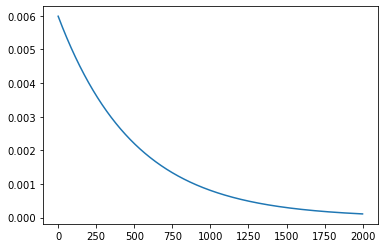

In [12]:
lr = []
start = 0.006
for i in range(2000):
    decay_factor1 = 0.998 ** (1 + 0.000000001 * i)
    start *= decay_factor1
    lr.append(start )
    
plt.plot(lr)


[0, 100, 200, 300, 400, 500, 600, 700, 800]


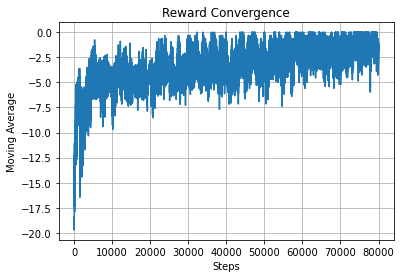

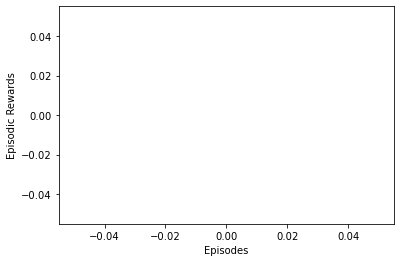

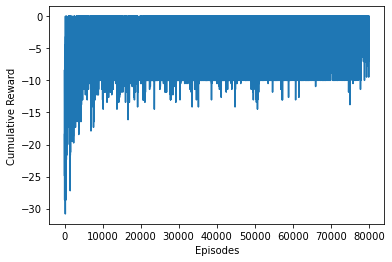

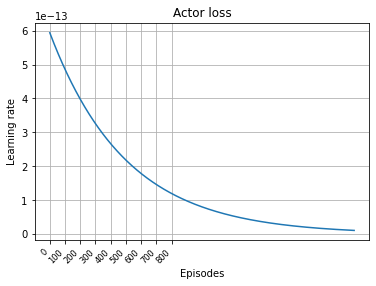

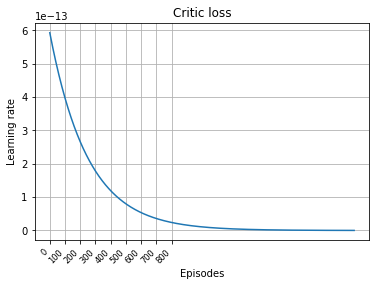

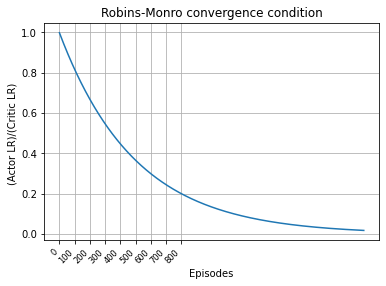

In [28]:
cum_reward_x_axis = [i for i in range(len(cumm_running_reward_list))]
ep_reward_x_axis = [i for i in range(len(episode_reward_list))]
loss_x_axis = [i for i in range(len(loss_list))]
actor_lr_x_axis = [i for i in range(len(actor_lr_list))]
critic_lr_x_axis = [i for i in range(len(critic_lr_list))]


tick_num = num_episodes//100
custom_x_values = [i*100 for i in range(0,tick_num+1)]
custom_x_values = sorted(custom_x_values)
print(custom_x_values)
custom_x_labels = [str(i) for i in custom_x_values]

smoothed_rewards = moving_average(cumm_running_reward_list, 10)
smoothed_rewards_x_axis = [i for i in range(len(smoothed_rewards))]

plt.plot(smoothed_rewards_x_axis, smoothed_rewards)
plt.xlabel("Steps")
plt.ylabel("Moving Average")
plt.title("Reward Convergence")
# plt.xticks(ticks=custom_x_values, labels=custom_x_labels, rotation=45, ha='right', size='small')
plt.grid(visible=True)
if save_plots:
    plt.savefig("Figures/RewardConvergence_"+problem_name+"_Node#_"+str(node_num)+"_EP_"+ str(num_episodes)+".png")
plt.show()

plt.plot(ep_reward_x_axis, episode_reward_list)
plt.xlabel("Episodes")
plt.ylabel("Episodic Rewards")
plt.show()
plt.plot(cum_reward_x_axis, cumm_running_reward_list)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.show()
plt.plot(actor_lr_x_axis, actor_lr_list)
plt.xticks(ticks=custom_x_values, labels=custom_x_labels, rotation=45, ha='right', size='small')
plt.grid(visible=True)
plt.title("Actor loss")
plt.xlabel("Episodes")
plt.ylabel("Learning rate")
if save_plots:
    plt.savefig("Figures/ActorLoss_"+problem_name+"_Node#_"+str(node_num)+"_EP_"+ str(num_episodes)+".png")
plt.show()
plt.plot(critic_lr_x_axis, critic_lr_list)
plt.xticks(ticks=custom_x_values, labels=custom_x_labels, rotation=45, ha='right', size='small')
plt.grid(visible=True)
plt.title("Critic loss")
plt.ylabel("Learning rate")
plt.xlabel("Episodes")
if save_plots:
    plt.savefig("Figures/CriticLoss_"+problem_name+"_Node#_"+str(node_num)+"_EP_"+ str(num_episodes)+".png")
plt.show()

plt.plot(critic_lr_x_axis,robins_monro_condition)
plt.xticks(ticks=custom_x_values, labels=custom_x_labels, rotation=45, ha='right', size='small')
plt.grid(visible=True)
plt.title("Robins-Monro convergence condition")
plt.ylabel("(Actor LR)/(Critic LR) ")
plt.xlabel("Episodes")
plt.show()

In [ ]:
# # Load the model 
# model = TransformerPolicy(len(initial_states[0]), len(action_space_size), mask_action_size, mask_rate, lb, ub)
# model.load_state_dict(torch.load('Models/'+problem_name+'policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth'))
# model.eval()



# min_rewards = []
# sim_number = 1
# optimum_reached = 0
# max_path_length = 1000
# start_time = Time.time()

# for sim in range(sim_number):

#     print("########################################################################")
#     print("########################################################################")
#     print("########################################################################")
#     print("########################################################################")
#     print("########################################################################")
    
#     # Convert dictionary values to a list of arrays
#     visited_states = [np.array(initial_states[0])]
#     visited_states = np.stack(visited_states)

#     #Initialize the environment.
#     env = Env(initial_states, # initial_state
#              num_episodes, # total_episodes
#              max_path_length,
#              50, # show_path_num
#              visited_states,  # visited_states
#              available_actions, # basis_moves
#              node_num, # node_num
#              0, # P
#              lb, #lb
#              )

#     # reset environment and episode reward
#     state = env.reset()
 

#     # for each episode, only run 9999 steps so that we don't
#     # infinite loop while learning
#     for t in range(max_path_length):

# #         action = select_best_action_transformer(model, state, action_space_values, t)
#         action = select_action_transformer(model, state, SavedAction, action_space_values, mask_range, t, True)
        
#         # take the action
#         next_state, reward, done, _ = env.step(action)


#         model.rewards.append(reward)
# #         ep_reward += reward

# #         print("State: \n", state)
# #         visualize_gaussian_distribution(model, state)
#         action_rounded = np.array(np.round(action), dtype=int)
#         all_actions = [np.multiply(action_rounded[i], available_actions[i]) for i in range(len(action_rounded))]
#         all_actions = np.stack(all_actions)
#         action = np.sum(all_actions, 0)
# #         print("Action: ", action)
# #         print("Training reward: ", reward)
# #         print(np.add(state, action))
# #         print("Next State: \n", next_state)
        
            
#         state = next_state


In [73]:
def compute_autocorrelation_norm(series, max_lag):
    """
    Compute the autocorrelation of the norm of vector-valued states.
    """
    series = np.array(series)  # Ensure it's a NumPy array
    norms = np.linalg.norm(series, axis=1)  # Compute norms of each vector
    n = len(norms)
    mean = np.mean(norms)
    autocorr_values = []
    
    for lag in range(1, max_lag + 1):
        cov = np.sum((norms[:n-lag] - mean) * (norms[lag:] - mean)) / n
        var = np.sum((norms - mean)**2) / n
        autocorr_values.append(cov / var)
    
    return autocorr_values

def plot_autocorrelation_norm(series, max_lag):
    """
    Plot the autocorrelation of the norm of vector-valued states.
    """
    autocorr_values = compute_autocorrelation_norm(series, max_lag)
    lags = range(1, max_lag + 1)
    
    plt.figure(figsize=(8, 6))
    plt.stem(lags, autocorr_values, use_line_collection=True)
    plt.title("Autocorrelation of MCMC Chain (Norm of States)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.grid()
    plt.show()


    
def compute_autocorrelation_vectorized(series, max_lag):
    """
    Compute the autocorrelation for each dimension of a vector-valued series.
    """
    series = np.array(series)  # Ensure it's a NumPy array
    n, d = series.shape  # n: number of samples, d: dimensions of state
    autocorr_values = np.zeros((max_lag, d))
    
    mean = np.mean(series, axis=0)  # Mean for each dimension
    
    for lag in range(1, max_lag + 1):
        for dim in range(d):  # Compute for each dimension
            cov = np.sum((series[:n-lag, dim] - mean[dim]) * 
                         (series[lag:, dim] - mean[dim])) / n
            var = np.sum((series[:, dim] - mean[dim])**2) / n
            autocorr_values[lag-1, dim] = cov / var
    
    return autocorr_values

def plot_autocorrelation_vectorized(series, max_lag):
    """
    Plot the autocorrelation for each dimension of a vector-valued series.
    """
    autocorr_values = compute_autocorrelation_vectorized(series, max_lag)
    lags = range(1, max_lag + 1)
    dims = autocorr_values.shape[1]
    
    plt.figure(figsize=(10, 6))
    for dim in range(dims):
        plt.stem(lags, autocorr_values[:, dim], label=f"Dimension {dim+1}", use_line_collection=True)
    
    plt.title("Autocorrelation of MCMC Chain (Each Dimension)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.legend()
    plt.grid()
    plt.show()

In [74]:
print("Problem name: ", problem_name)

model = TransformerPolicy(len(initial_states[0]), len(action_space_size), mask_action_size, mask_rate, lb, ub)
model.load_state_dict(torch.load('Models/'+problem_name+'policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth'))
model.eval()


step = 0
path = []
path_length = 5000

state = env.reset()
path.append(state)
done = False


#Initialize the environment.
env = Env(initial_states, # initial_state
     1, # total_episodes
     max_path_length,
     50, # show_path_num
     visited_states,  # visited_states
     available_actions, # basis_moves
     node_num, # node_num
     0, # P
     lb, #lb
     False)


for i in range(path_length):
#     action = select_action_transformer(model, state, SavedAction, action_space_values, mask_range, i, True)
#     next_state, reward, done, info = env.step(action)
#     state = next_state
#     path.append(state)
    action = select_action_transformer(model, state, SavedAction, action_space_values, mask_range, i, True)
    
    action_rounded = np.array(np.round(action), dtype=int)
    all_actions = [np.multiply(action_rounded[i], available_actions[i]) for i in range(len(action_rounded))]
    all_actions = np.stack(all_actions)
    action = np.sum(all_actions, 0)
    
    next_state = np.add(state, action)
    
    if all(coord >= 0 for coord in next_state):
#         if next_state.tolist() not in discovered_states:
#             discovered_states.append(next_state)
#         print("#########")
#         print(action)
#         print(next_state)
        path.append(next_state)
#     next_state, reward, done, info = env.step(action)
    state = next_state
#     path.append(state)
    
#     if i%100 == 0:
#         print(f'We discovered {len(discovered_state)} states.')


Problem name:  4x4LargeValues_


Length of the chain is 2539


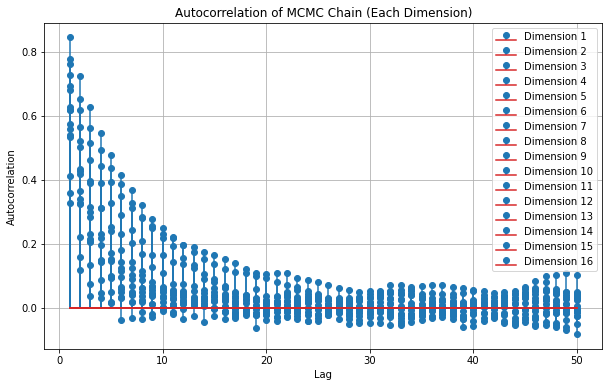

In [75]:
print(f'Length of the chain is {len(path)}')
# plot_autocorrelation_norm(np.array(path), max_lag=50)
plot_autocorrelation_vectorized(np.array(path), max_lag=50)

In [9]:
from stats_functions import find_exchangable_sample, compute_chi_square


print("Problem name: ", problem_name)

model = TransformerPolicy(len(initial_states[0]), len(action_space_size), mask_action_size, mask_rate, lb, ub)
model.load_state_dict(torch.load('Models/'+problem_name+'policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth'))
model.eval()

sim_num = 100 # number of times we run the algorithm.
chain_num = 100 # 100 points per simulation.
max_path_length = 100
p_list = []


start_time = Time.time()


for sim in range(sim_num):
    
    print("#############################################################################################")
    print("#############################################################################################")
    print("#############################################################################################")
    print("#############################################################################################")
    print("#############################################################################################")
    print("#############################################################################################")
    print("#######################  SIM NUMBER: ", sim, " #####################")
    # Convert dictionary values to a list of arrays
    visited_states = [np.array(initial_states[0])]
    visited_states = np.stack(visited_states)

    computed_sample = find_exchangable_sample(model,
                                                SavedAction,
                                                initial_states,
                                                num_episodes,
                                                max_path_length,
                                                visited_states,
                                                available_actions,
                                                action_space_values,
                                                mask_range,
                                                node_num,
                                                lb,
                                                ub,
                                                chain_num)

    nodes = [i for i in range(node_num)]

    p = compute_chi_square(problem_name, initial_states[0], margin, computed_sample, nodes, num_episodes)
    p_list.append(p)
    


end_time = Time.time()
print(f'It took {(end_time-start_time)/60} minutes to run {num_episodes} episodes.')

Problem name:  4x4LargeValues_
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#######################  SIM NUMBER:  0  #####################
(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]
 [ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]]
Expected table: 
 [ 1.31  4.69  1.31  4.69  4.69 16.81  4.69 16.81  1.31  4.69  1.31  4.69
  4.69 16.81  4.69 16.81] (16,)
Initial Chi-square:  483.98
The p-value of seeing obs as least as extreme as u_0:  0.0
################

(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]
 [ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]]
Expected table: 
 [ 1.31  4.69  1.31  4.69  4.69 16.81  4.69 16.81  1.31  4.69  1.31  4.69
  4.69 16.81  4.69 16.81] (16,)
Initial Chi-square:  483.98
The p-value of seeing obs as least as extreme as u_0:  0.0
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#######################  SIM NUMBER:  9  #####################
(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81

(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]
 [ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]]
Expected table: 
 [ 1.31  4.69  1.31  4.69  4.69 16.81  4.69 16.81  1.31  4.69  1.31  4.69
  4.69 16.81  4.69 16.81] (16,)
Initial Chi-square:  483.98
The p-value of seeing obs as least as extreme as u_0:  0.0
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#######################  SIM NUMBER:  18  #####################
(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.8

(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]
 [ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]]
Expected table: 
 [ 1.31  4.69  1.31  4.69  4.69 16.81  4.69 16.81  1.31  4.69  1.31  4.69
  4.69 16.81  4.69 16.81] (16,)
Initial Chi-square:  483.98
The p-value of seeing obs as least as extreme as u_0:  0.0
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#######################  SIM NUMBER:  27  #####################
(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.8

(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]
 [ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]]
Expected table: 
 [ 1.31  4.69  1.31  4.69  4.69 16.81  4.69 16.81  1.31  4.69  1.31  4.69
  4.69 16.81  4.69 16.81] (16,)
Initial Chi-square:  483.98
The p-value of seeing obs as least as extreme as u_0:  0.0
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#######################  SIM NUMBER:  36  #####################
(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.8

(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]
 [ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]]
Expected table: 
 [ 1.31  4.69  1.31  4.69  4.69 16.81  4.69 16.81  1.31  4.69  1.31  4.69
  4.69 16.81  4.69 16.81] (16,)
Initial Chi-square:  483.98
The p-value of seeing obs as least as extreme as u_0:  0.0
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#######################  SIM NUMBER:  45  #####################
(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.8

(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]
 [ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]]
Expected table: 
 [ 1.31  4.69  1.31  4.69  4.69 16.81  4.69 16.81  1.31  4.69  1.31  4.69
  4.69 16.81  4.69 16.81] (16,)
Initial Chi-square:  483.98
The p-value of seeing obs as least as extreme as u_0:  0.0
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#######################  SIM NUMBER:  54  #####################
(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.8

(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]
 [ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]]
Expected table: 
 [ 1.31  4.69  1.31  4.69  4.69 16.81  4.69 16.81  1.31  4.69  1.31  4.69
  4.69 16.81  4.69 16.81] (16,)
Initial Chi-square:  483.98
The p-value of seeing obs as least as extreme as u_0:  0.0
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#######################  SIM NUMBER:  63  #####################
(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.8

(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]
 [ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]]
Expected table: 
 [ 1.31  4.69  1.31  4.69  4.69 16.81  4.69 16.81  1.31  4.69  1.31  4.69
  4.69 16.81  4.69 16.81] (16,)
Initial Chi-square:  483.98
The p-value of seeing obs as least as extreme as u_0:  0.0
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#######################  SIM NUMBER:  72  #####################
(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.8

(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]
 [ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]]
Expected table: 
 [ 1.31  4.69  1.31  4.69  4.69 16.81  4.69 16.81  1.31  4.69  1.31  4.69
  4.69 16.81  4.69 16.81] (16,)
Initial Chi-square:  483.98
The p-value of seeing obs as least as extreme as u_0:  0.0
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#######################  SIM NUMBER:  81  #####################
(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.8

(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]
 [ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]]
Expected table: 
 [ 1.31  4.69  1.31  4.69  4.69 16.81  4.69 16.81  1.31  4.69  1.31  4.69
  4.69 16.81  4.69 16.81] (16,)
Initial Chi-square:  483.98
The p-value of seeing obs as least as extreme as u_0:  0.0
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#######################  SIM NUMBER:  90  #####################
(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.8

(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]
 [ 1.31  4.69  1.31  4.69]
 [ 4.69 16.81  4.69 16.81]]
Expected table: 
 [ 1.31  4.69  1.31  4.69  4.69 16.81  4.69 16.81  1.31  4.69  1.31  4.69
  4.69 16.81  4.69 16.81] (16,)
Initial Chi-square:  483.98
The p-value of seeing obs as least as extreme as u_0:  0.0
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#############################################################################################
#######################  SIM NUMBER:  99  #####################
(4, 4) [[ 1.31  4.69  1.31  4.69]
 [ 4.69 16.8

In [10]:
print(p_list)
print("Average p-value: ", sum(p_list)/len(p_list))
np.save('Models/'+problem_name+'p_values_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.npy', p_list)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Average p-value:  0.0


In [11]:
def calculate_frequencies(data_list):
    from collections import Counter
    # Use Counter to calculate frequencies
    frequency_dict = dict(Counter(data_list))
    return frequency_dict

#Pick the file to the problem:
problem_name = '4x4LargeValues_'
# problem_name = '4x4_01_Values_'
# problem_name = 'Dobra_'
# problem_name = 'mediumComponent'

p_list = np.load('Models/'+problem_name+'p_values_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.npy')
freq_dict = calculate_frequencies(p_list)
freq_dict = dict(sorted(freq_dict.items()))
print(freq_dict)

{0.0: 100}


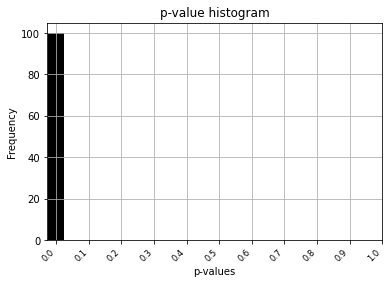

In [12]:
custom_x_values = [np.round(i*0.1,2) for i in range(len(list(freq_dict.keys())) + 10)]
custom_x_values = sorted(custom_x_values)
custom_x_labels = [str(i) for i in custom_x_values]
widts = [0.05 for i in range(len(freq_dict.keys()))]
plt.bar(freq_dict.keys(), freq_dict.values(), width = widts, color='black')
plt.xticks(ticks=custom_x_values, labels=custom_x_labels, rotation=45, ha='right', size='small')
plt.xlabel('p-values')
plt.ylabel('Frequency')
plt.title('p-value histogram')
plt.grid(visible=True)
plt.savefig("Figures/p_value_histogram_"+problem_name+"_Node#_"+str(node_num)+"_EP_"+ str(num_episodes)+".png")
plt.show()

In [ ]:
#0/1:  34 min for p-value computation, training:  7min for 1000 episodes 100 timesteps. 
#larger: 48 min for p-value computation, training:  14min for 1000 episodes 100 timesteps.
# larger with bigger coeffs: 60min for p-value computation, training: 9min for 1000 episodes 100 timesteps

# Dobra: training finished in 114 minutes for 1000 episodes. p_value computation: 82 minutes.


# Check whether the chi distribution of all exchangable samples match the chi square distribution with 9 d.o.f.